<a href="https://colab.research.google.com/github/stbiadmin/myopia/blob/main/image_degrader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init and Setup

In [2]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:

###uncomment to install non-collab-native libraries (run once)
!pip install thispersondoesnotexist
!pip install ipython ipykernel --upgrade
!pip install asyncio

## Install GCS packages
!pip install --q fsspec
!pip install --q gcsfs

##Install Vectice Python library 
!pip install --q vectice[github]==2.2.3


#Import the required packages
from vectice import Experiment
from vectice.api.json import ModelType
from vectice.api.json import JobType
from vectice.api.json import JobArtifactType
from vectice.api.json import ModelVersionStatus
from vectice.api.json.artifact_version import VersionStrategy
import logging
import os
logging.basicConfig(level=logging.INFO)


#import libraries
from thispersondoesnotexist import get_online_person, get_checksum_from_picture,save_picture, Person
import skimage as sk
import skimage.io as skio
import skimage.color as color
import numpy as np
import matplotlib.pyplot as plt
import random
import asyncio
import cv2
import torch
from scipy import signal
from scipy import misc
from scipy import interpolate
from scipy import ndimage
from skimage.transform import resize
from IPython.core.display import clear_output
from time import sleep
import shutil
import os


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#move imagenet-1k resources into project directory and import them
shutil.copy('/content/drive/MyDrive/Colab Notebooks/vectice_demos/classes.py','/content/')
import classes

In [3]:
#await requires ipython update, this checks version
import IPython
IPython.version_info

(7, 34, 0, '')

In [30]:
#Verify if Vectice python library was installed
!pip3 show vectice

Name: vectice
Version: 2.2.3
Summary: Vectice Python library
Home-page: https://github.com/vectice/vectice-python
Author: Vectice Inc.
Author-email: sdk@vectice.com
License: Apache License 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: python-dotenv, urllib3, requests
Required-by: 


In [6]:
# Specify the API endpoint for Vectice.
os.environ['VECTICE_API_ENDPOINT']= "app.vectice.com"

# To use the Vectice Python library, you first need to authenticate your account using an API key.
os.environ['VECTICE_API_TOKEN'] = "lM56j25kR.lAGBa8yxQEVW2egJvY7ZOlM56j25kRodDNrb9nm0LwX34jpP6z"

# Add you project id. The project id can be found in the project settings page in the Vectice UI
project_id = 5194

## Helper Functions

In [7]:
def warpit(im,imname, nsynths, path):
    if len(im.shape) != 3: #convert grayscale to RGB if needed
        im = color.gray2rgb(im)

    for i in range(nsynths):
        dim = 256
        j = random.randint(1,50) + 30; # JPEG compression
        b = 3*random.random() #blur
        g = random.random() + 1; # gamma
        w = 4*np.random.randn() # local geometric warping
        n = random.random()/ 8 # additive noise

        gkern_1D = cv2.getGaussianKernel(11,b+np.finfo(float).eps)
        gkern_2D = np.outer(np.transpose(gkern_1D), gkern_1D )

        im_res = resize(im, [dim,dim])
        x = np.array(list(range(0,dim)))
        y = np.array(list(range(0,dim)))
        x1 = np.array(list(range(1,dim,16)))
        y1 = np.array(list(range(1,dim,16)))

        [xramp,yramp] = np.meshgrid(x,y)
        [xramp2,yramp2] = np.meshgrid(x1,y1)

        xramp2 = xramp2 + w*np.random.randn(xramp2.shape[0],xramp2.shape[1])
        yramp2 = yramp2 + w*np.random.randn(yramp2.shape[0],yramp2.shape[1])

        xramp2 = resize(xramp2, [dim, dim])
        yramp2 = resize(yramp2, [dim, dim])

        im2 = im_res

        for z in range(0,3):
            im2[:,:,z] = signal.convolve2d(im2[:,:,z],gkern_2D , mode='same')
            im2[:,:,z] = ndimage.map_coordinates(im2[:,:,z], [yramp2,xramp2], mode='nearest')
            
        im2 = np.sign(255 * (im2/255)) * np.abs(255 * (im2/255))**g #numpy doesn't allow fractional negative numbers..Workaround
        im2 = im2 + n*np.random.randn(xramp2.shape[1],xramp2.shape[0], 3); # additive noise

        im2 = im2 - im2.min()
        im2 = 255 * im2/im2.max() # scale into [0,255]
        
        plt.imsave('temp.jpg', im2.astype('uint8'))
        im2 = cv2.imread('temp.jpg')
        
        num_rows, num_cols = im2.shape[:2]
        center = (num_cols/2, num_rows/2)
        angle = random.randrange(-5,5,1)
        rot_mat = cv2.getRotationMatrix2D(center,angle, scale =1)
        tx, ty = 10*np.random.randn(), 10* np.random.randn()
        t_map = np.array([
            [1, 0, tx],
            [0, 1, ty]
        ], dtype=np.float32)
        im2 = cv2.warpAffine(im2,rot_mat,(num_cols, num_rows))
        im2 = cv2.warpAffine(im2,t_map,(num_cols, num_rows))
        im2 = im2[30: -30,30: -30,:]
        
        clear_output(wait=True)
        plt.figure(figsize=(10,10))
        plt.subplot(1,2,1)
        plt.imshow(im)
        plt.subplot(1,2,2)
        plt.imsave(path + imname +'_'+str(i)+'.jpg', cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
        plt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
        plt.show()
        sleep(0.1)
       
    print(imname + " processed!")   
    
    return


In [8]:
#save sample data in the sample data folder
def copy_data(dataset,from_path,to_path):
  for file in dataset:
    shutil.copy(from_path+file,to_path)
    
  return

## Data Generation and Preparation

#### TPDNE Data Loading and Preparation

In [ ]:
# We create our first experiment for data preparation and specify the workspace and the project we will be working on
# Each experiment only contains one job. Each invokation of the job is called a run.
# autocode = True enables you to track your git changes for your code automatically every time you execute a run (see below).
experiment = Experiment(job="Data Generation and Preparation (faces)_2", project=project_id, job_type=JobType.PREPARATION, auto_code=True)

In [ ]:
# The Vectice library automatically detects if there have been changes to the dataset you are using.
# If it detects changes, it will generate a new version of your dataset automatically. 
# For this tutorial, we changed the data since Albert left the company.
# So, the Vectice Python library will create a new dataset version when this code is executed for the first time.
experiment.add_dataset_version(dataset="GAN-created Faces + Random Degradation", version_strategy=VersionStrategy.AUTOMATIC)

In [ ]:
# The created dataset version and code version will be automatically attached as inputs of the run
experiment.start(run_properties={"NumFaces": "1", "NumSynths": "0"})

Run(id=15916, job=Job(name=Data Generation and Preparation (faces)_2, id=9556, description=None, type=JobType.PREPARATION), name=Run 2022-05-29T03:09:22.303767, system_name=None, start_date=2022-05-29 03:09:23.594647, end_date=None, duration=None, status=RunStatus.STARTED, inputs=[ArtifactReference(code=None, dataset=GAN-created Faces + Random Degradation, model=None, version_number=None, version_id=None, version_name=None, version_strategy=VersionStrategy.AUTOMATIC, description=None, )], outputs=[])

In [ ]:
#if the "faces" folder doesn't exist, create it
if not os.path.exists('../content/faces/TPDNE/'):
  os.makedirs('../content/faces/TPDNE/Original')
  os.makedirs('../content/faces/TPDNE/Degraded/')
else:
  print('Faces folder already exists, skipping...')

In [ ]:
n = 10 # number of raw fake faces to download
m = 5 #number of synthetic degraded faces to generate
path = '/content/faces/TPDNE/Original/'

In [ ]:
for i in range(n):
  # Using function
  picture =  await get_online_person()
  checksum2 = get_checksum_from_picture(picture)  # Method is optional, defaults to "md5"
  await save_picture(picture, path+str(checksum2)+'.jpg')

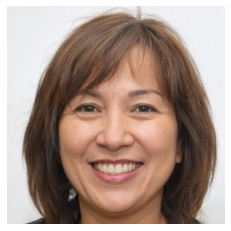

In [ ]:
#show all downloaded images
for identity in os.listdir('/content/faces/TPDNE/Original/'):
  clear_output(wait=True)
  tmp_img = plt.imread(path+identity)
  plt.imshow(tmp_img)
  plt.axis('off')
  plt.show()
  sleep(0.1)

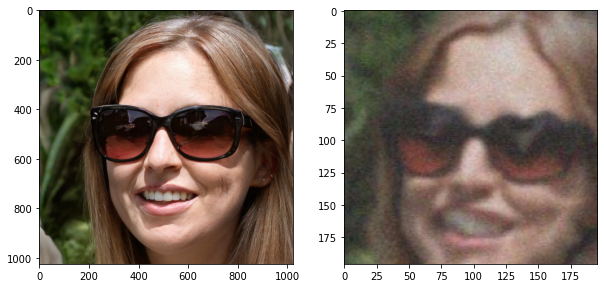

f7f582c7ac073ebd397fc58a4e074ad2 processed!


In [ ]:
#cereate random warps of downloaded images
for filename in os.listdir(path):
    if filename.endswith(".jpg"):
        img = plt.imread(path+filename)
        warpit(img, filename[:-4], m)

In [ ]:
experiment.complete()

#### ImageNet-1k Data Loading and Preparation

In [12]:
#n = number of images to sample n_synths = number of synthetics to create
n = 10
n_synths = 5

In [9]:
# We create our first experiment for data preparation and specify the workspace and the project we will be working on
experiment = Experiment(job="Data Generation and Preparation (imagenet)_1", project=project_id, job_type=JobType.PREPARATION, auto_code=True)

In [10]:
# The Vectice library automatically detects if there have been changes to the dataset you are using.
# If it detects changes, it will generate a new version of your dataset automatically. 
# For this tutorial, we changed the data since Albert left the company.
# So, the Vectice Python library will create a new dataset version when this code is executed for the first time.
experiment.add_dataset_version(dataset="GAN-created Imagenet Objects + Random Degradation", version_strategy=VersionStrategy.AUTOMATIC)

ArtifactReference(code=None, dataset=GAN-created Imagenet Objects + Random Degradation, model=None, version_number=None, version_id=None, version_name=None, version_strategy=VersionStrategy.AUTOMATIC, description=None, )

In [13]:
# Because we are using Colab we are going to declare a reference to the code
input_code = experiment.add_code_version_uri(git_uri="https://github.com/stbiadmin/myopia",
                                             entrypoint="image_degrader.ipynb") 

In [14]:
# The created dataset version and code version will be automatically attached as inputs of the run
experiment.start(run_properties={"NumImages": n, "NumSynths": n_synths})

Run(id=16849, job=Job(name=Data Generation and Preparation (imagenet)_1, id=10066, description=None, type=JobType.PREPARATION), name=Run 2022-06-05T17:17:01.899239, system_name=None, start_date=2022-06-05 17:17:02.988424, end_date=None, duration=None, status=RunStatus.STARTED, inputs=[ArtifactReference(code=None, dataset=GAN-created Imagenet Objects + Random Degradation, model=None, version_number=None, version_id=None, version_name=None, version_strategy=VersionStrategy.AUTOMATIC, description=None, ), ArtifactReference(code=1001, dataset=None, model=None, version_number=None, version_id=2625, version_name=None, version_strategy=None, description=None, )], outputs=[])

In [21]:
#if the "degraded_data" folder doesn't exist, create it
if not os.path.exists('../content/imagenet/degraded_data/'):
  os.makedirs('../content/imagenet/degraded_data/')
  if not os.path.exists('../content/imagenet/sample_data/'):
    os.makedirs('../content/imagenet/sample_data/')
else:
  print('Both folders already exist, skipping step for now...')

In [15]:
#set the path to the dataset
path = '/content/drive/MyDrive/Vectice Demos/Myopia/data/'
#set path to sample data
sample_path = '/content/imagenet/sample_data/'
#set path to cropped sample data
degraded_path = '/content/imagenet/degraded_data/'

In [16]:
#load the ground truth labels
'/content/drive/MyDrive/Vectice Demos/Myopia/devkit/ILSVRC2013_devkit/data/ILSVRC2013_clsloc_validation_ground_truth.txt'

'/content/drive/MyDrive/Vectice Demos/Myopia/devkit/ILSVRC2013_devkit/data/ILSVRC2013_clsloc_validation_ground_truth.txt'

In [17]:
#get a list of all of the filenames of all images in the imagnet validation dataset
file_list = os.listdir('/content/drive/MyDrive/Vectice Demos/Myopia/data')

In [18]:
#create a random sample of n images 
sample_images = random.sample(file_list,n)

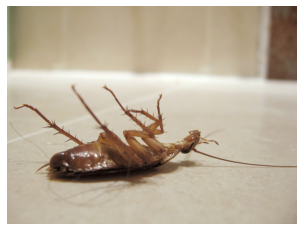

In [19]:
#visualize the sample images
for image in sample_images:
  clear_output(wait=True)
  tmp = plt.imread(path + image)
  plt.imshow(tmp)
  plt.axis('off')
  plt.show()
  sleep(0.1)

In [22]:
#copy the sample data to the correct folder
copy_data(sample_images, path, sample_path)

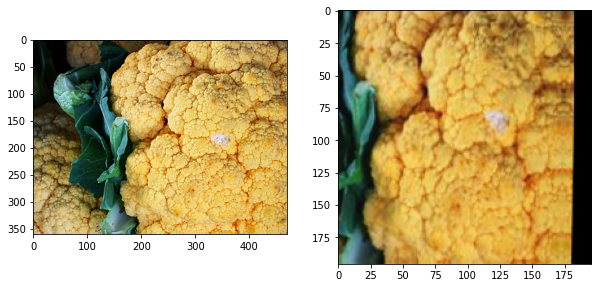

ILSVRC2012_val_00007774_n07715103.JPEG processed!


In [23]:
#degrade images 
for image in os.listdir(sample_path):
  tmp = plt.imread(sample_path + image)
  warpit(tmp,image,n_synths,degraded_path)

In [24]:
experiment.complete()

In [97]:
#copy degraded results to gdrive for later access
deg_sample = os.listdir(degraded_path)
copy_data(deg_sample, degraded_path, '/content/drive/MyDrive/Vectice Demos/Myopia/degraded_sample/')

In [100]:
#copy sample results to gdrive for later access
copy_data(sample_images, sample_path,'/content/drive/MyDrive/Vectice Demos/Myopia/sample_images/')